In [9]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [2]:
# Load the PubMed RCT20k dataset
dataset = load_dataset("armanc/pubmed-rct20k")
train_data = dataset['train']
valid_data = dataset['validation']

print(f"Loaded dataset: {len(train_data)} training samples, {len(valid_data)} validation samples.")

Repo card metadata block was not found. Setting CardData to empty.


Loaded dataset: 176642 training samples, 29672 validation samples.


In [3]:
# Define label mappings
target_names = ["background", "objective", "methods", "results", "conclusions"]
label2id = {name: idx for idx, name in enumerate(target_names)}
id2label = {idx: name for idx, name in enumerate(target_names)}

print(f"Label mappings: {label2id}")

Label mappings: {'background': 0, 'objective': 1, 'methods': 2, 'results': 3, 'conclusions': 4}


In [4]:
# Load pretrained SciBERT model
model_name = "allenai/scibert_scivocab_uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
encoder = AutoModel.from_pretrained(model_name).to(device)
encoder.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(31090, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [5]:
# Define function to extract last4-layer mean pooled CLS embeddings
def get_pooled_cls_embeddings(text_list, batch_size=16):
    embeddings = []
    for i in tqdm(range(0, len(text_list), batch_size), desc="Extracting embeddings"):
        batch_texts = text_list[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=256).to(device)
        with torch.no_grad():
            outputs = encoder(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states
        last_four = torch.stack(hidden_states[-4:], dim=0)
        pooled = last_four.mean(dim=0)[:, 0, :]
        embeddings.append(pooled.cpu().numpy())
    return np.vstack(embeddings)

In [6]:
# Check if cached embeddings exist
if os.path.exists("train_embeddings_logistic.npy") and os.path.exists("valid_embeddings_logistic.npy"):
    X_train = np.load("train_embeddings_logistic.npy")
    y_train = np.load("train_labels_logistic.npy", allow_pickle=True)
    X_valid = np.load("valid_embeddings_logistic.npy")
    y_valid = np.load("valid_labels_logistic.npy", allow_pickle=True)
else:
    # Build embeddings
    train_texts = [item['text'] for item in train_data]
    y_train = np.array([label2id[item['label']] for item in train_data])
    X_train = get_pooled_cls_embeddings(train_texts)

    valid_texts = [item['text'] for item in valid_data]
    y_valid = np.array([label2id[item['label']] for item in valid_data])
    X_valid = get_pooled_cls_embeddings(valid_texts)

    np.save("train_embeddings_logistic.npy", X_train)
    np.save("train_labels_logistic.npy", y_train)
    np.save("valid_embeddings_logistic.npy", X_valid)
    np.save("valid_labels_logistic.npy", y_valid)
    print("Saved embeddings")

Extracting embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1855/1855 [00:50<00:00, 36.91it/s]


Saved embeddings


In [10]:
# Train logistic regression
clf = LogisticRegression(max_iter=3000, random_state=42)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000, random_state=42)

In [13]:
# Save the trained classifier
joblib.dump(clf, "logistic_classifier.pkl")
print("Saved Logistic Regression model")

Saved Logistic Regression model



Classification Report:
              precision    recall  f1-score   support

  background     0.6612    0.7446    0.7004      2925
   objective     0.7645    0.5669    0.6510      2376
     methods     0.9211    0.9570    0.9387      9948
     results     0.9213    0.9177    0.9195      9841
 conclusions     0.8517    0.8324    0.8419      4582

    accuracy                         0.8725     29672
   macro avg     0.8240    0.8037    0.8103     29672
weighted avg     0.8723    0.8725    0.8709     29672



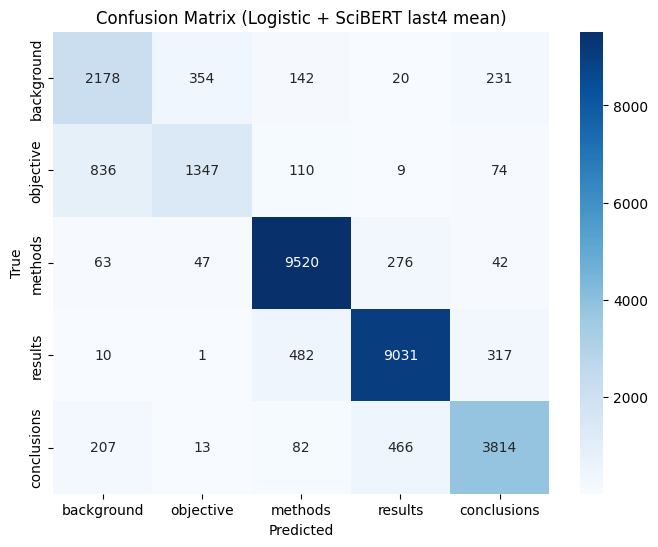

In [12]:
# Evaluate performance
y_pred = clf.predict(X_valid)

print("\nClassification Report:")
report = classification_report(y_valid, y_pred, labels=[0,1,2,3,4], target_names=target_names, digits=4)
print(report)

# Save report
with open("classification_report_logistic.txt", "w") as f:
    f.write(report)

# Plot confusion matrix
cm = confusion_matrix(y_valid, y_pred, labels=[0,1,2,3,4])
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Logistic + SciBERT last4 mean)')
plt.savefig("confusion_matrix_logistic.png")
plt.show()